In [1]:
import sys
import os
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

Mounted at /content/drive
Pytorch version: 2.2.1+cu121
Device name: Tesla T4


In [4]:
# import libraries
import torch
import torch.nn as nn
import torchtext
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn.functional as F
from transformers import AdamW, DistilBertTokenizerFast, DistilBertModel
import optuna
from optuna.trial import TrialState
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
import time
import matplotlib.pyplot as plt
import seaborn as sns

# useful .py
from settings import * # settings
from dataset import * # data pre-processing
from model import * # models
from optimization import * # model selection, training, evaluation
from uncertainty import * # uncertainty quantification and xai

import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})

### **Explaining uncertainty for TTT: wine100 dataset**


In [ ]:
# select dataset and seed to compute Shapley values
DATASET = "wine_100"
set_seed = 0
PATIENCE = 4

# load settings
FILENAME, categorical_var, numerical_var, text_var, MAX_LEN_QUANTILE, N_CLASSES, WEIGHT_DECAY, FACTOR, N_EPOCHS, split_val, CRITERION, N_SEED, DROPOUT= load_settings(dataset = DATASET)

perf_results = pd.DataFrame()
i = 0

SEED = set_seed
MODEL_TYPE = "TTT"

start = time.time()
perf_results.loc[i,"seed"] = SEED
perf_results.loc[i,"model type"] = MODEL_TYPE

# GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load and prepare dataset
df = preprocess_dataset(DATASET, MODEL_TYPE)

# Train/Test split
df, target = train_test_split(df, test_size = split_val, random_state = SEED)

# text max length
MAX_LEN = int(np.quantile(df.apply(lambda row : len(row[text_var].split()), axis=1).values, q = [MAX_LEN_QUANTILE]).item())
perf_results.loc[i,"max text length"] = MAX_LEN

# vocabulary construction
vocab2index, VOCAB_SIZE, words = vocabulary(df, text_field = text_var)
perf_results.loc[i,"vocab size"] = VOCAB_SIZE

# encode text on Source and Target
df['encoded_var'] = df[text_var].apply(lambda x: encode_sentence(x,vocab2index,max_len=MAX_LEN))
target['encoded_var'] = target[text_var].apply(lambda x: encode_sentence(x,vocab2index,max_len=MAX_LEN))

# Numerical variables pre-processing
numerical_var_scaled = standardScaling(df, target, numerical_var)
QUANTILES = []
for var in numerical_var_scaled:
    QUANTILES.append(np.quantile(df[var].values, q = [0., 0.2, 0.4, 0.6, 0.8, 1.]))

NUM_NUMERICAL_VAR = len(numerical_var)

# Categorical variables pre-processing
if MODEL_TYPE in ["LateFuse", "TFN"]:
    categorical_var_oe = oneHotEncoding(df, target, categorical_var)
    NUM_CAT_VAR = len(categorical_var_oe)
    CAT_VOCAB_SIZES = None
else:
    categorical_var_oe, CAT_VOCAB_SIZES = ordinalEncoding(df, target, categorical_var)
    NUM_CAT_VAR = len(categorical_var)

# train / validation split
df_train, df_validation = train_test_split(df, test_size = split_val, random_state = SEED)
perf_results.loc[i,"training size"] = df_train.shape[0]
perf_results.loc[i,"test size"] = target.shape[0]

# prepare custom datasets
dataset_train, dataset_validation, dataset_target = prepareCustomDatasets(df_train, df_validation, target,
                                                                      encoded_text_var = 'encoded_var',
                                                                      categorical_var = categorical_var_oe,
                                                                      numerical_var = numerical_var_scaled,
                                                                      label = 'Y')

# import hyper-parameters from Bayesian Optimization (directory perf_results/)
res = pd.read_csv("results/"+DATASET+"_perf_results.csv")
res = res[(res["model type"]=="TTT") & (res["seed"]==SEED)]
LR, BATCH_SIZE, D_MODEL, N_LAYERS, N_HEADS = res[["LR",	"BATCH_SIZE",	"D_MODEL",	"N_LAYERS",	"N_HEADS"]].values[0]
LR, BATCH_SIZE, D_MODEL, N_LAYERS, N_HEADS = LR, int(BATCH_SIZE), int(D_MODEL), int(N_LAYERS), int(N_HEADS)

# same dimension for Feed Forward and Fully Connected
D_FF = D_MODEL
D_FC = D_MODEL

perf_results.loc[i,"LR"] = LR
perf_results.loc[i,"BATCH_SIZE"] = BATCH_SIZE
perf_results.loc[i,"D_MODEL"] = D_MODEL
perf_results.loc[i,"N_LAYERS"] = N_LAYERS
perf_results.loc[i,"N_HEADS"] = N_HEADS

# create loaders: training + validation (Source) and Target
loader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True)
loader_validation = DataLoader(dataset_validation, batch_size = BATCH_SIZE, shuffle = True)
loader_target = DataLoader(dataset_target, batch_size = BATCH_SIZE)

# model initialization
model = init_model(model_type = MODEL_TYPE,
                    d_model = D_MODEL,
                    max_len = MAX_LEN,
                    vocab_size = VOCAB_SIZE,
                    cat_vocab_sizes = CAT_VOCAB_SIZES,
                    num_cat_var = NUM_CAT_VAR,
                    num_numerical_var = NUM_NUMERICAL_VAR,
                    quantiles = QUANTILES,
                    n_heads = N_HEADS,
                    d_ff = D_FF,
                    n_layers = N_LAYERS,
                    dropout = DROPOUT,
                    d_fc = D_FC,
                    n_classes = N_CLASSES,
                    seed = SEED,
                    device=device).to(device)

# number of trainable parameters
perf_results.loc[i,"trainable parameters"] = sum(p.numel() for p in model.parameters() if p.requires_grad)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# training or load checkpoint
model = training(model, loader_train,  N_EPOCHS, loader_validation, CRITERION, optimizer, PATIENCE, FACTOR, MODEL_TYPE, SEED, verbose=True, device = device, early_stopping = True)

# model evaluation and uncertainty quantification
model.eval()

# target
perf, labels, preds, text_preds, tabular_preds = performance(model, loader_target, MODEL_TYPE, SEED, device)
perf_results.loc[i,"performance"] = perf

elapsed_time = time.time()-start
perf_results.loc[i,"time"] = elapsed_time

i+=1

display(perf_results)



,seed,model type,max text length,vocab size,training size,test size,LR,BATCH_SIZE,D_MODEL,N_LAYERS,N_HEADS,trainable parameters,performance,time
0,0.0,TTT,55.0,17215.0,70905.0,22158.0,0.00071,32.0,64.0,3.0,8.0,1281224.0,0.67479,64.742448


**Construct Dc, Du, and value functions**

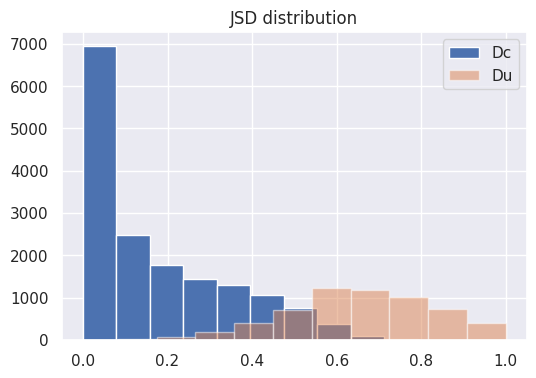

In [ ]:
## Construct Du and Dc: datasets with certain and uncertain predictions

# compute Jensen Shannon Divergence between text and tabular softmax distributions (value function#1)
text_preds, text_softs, tabular_preds, tabular_softs, jsd, preds = value_function_jsd(loader_target, model, model_type = MODEL_TYPE, seed = SEED, device = device)
data = target.reset_index(drop=True)
p_text = ["p_text"+str(i) for i in range(text_softs.shape[1])]
p_tab = ["p_tab"+str(i) for i in range(tabular_softs.shape[1])]
data[p_text] = text_softs
data[p_tab] = tabular_softs
data["preds"] = preds
data["text_preds"] = text_preds
data["tab_preds"] = tabular_preds
data["jsd"] = jsd

# compute uncertainty
data["is_uncertain"] = (data.text_preds!=data.tab_preds).astype(int)

# split dataset into certain and uncertain
Dc = data[data["is_uncertain"]==0].copy()
Du = data[data["is_uncertain"]==1].copy()

# jsd distribution for Du and Dc
plt.title("JSD distribution")
Dc["jsd"].hist(density = False, figsize = (6,4) )
Du["jsd"].hist(density = False, alpha = 0.5, figsize = (6,4))
plt. legend(['Dc', 'Du'])

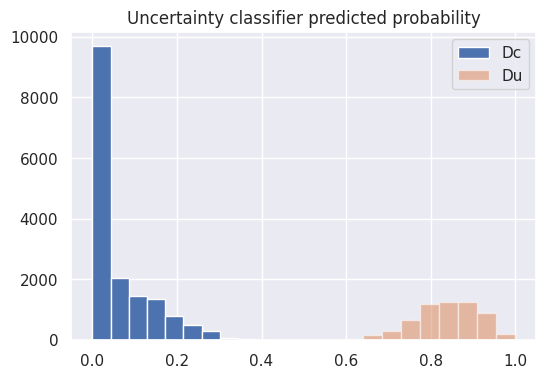

In [ ]:
# value function#2: uncertainty classifier
rf_classifier = uncertainty_classifier(X=data[p_text+p_tab], y=data["is_uncertain"], seed= SEED)

# add uncertainty classifier prediction in Dc and Du
plt.title("Uncertainty classifier predicted probability")
Dc["uncertainty_classifier"]=rf_classifier.predict_proba(Dc[p_text+p_tab])[:,1]
Du["uncertainty_classifier"]=rf_classifier.predict_proba(Du[p_text+p_tab])[:,1]
Dc["uncertainty_classifier"].hist(density = False, figsize = (6,4) )
Du["uncertainty_classifier"].hist(density = False, alpha = 0.5, figsize = (6,4))
plt. legend(['Dc', 'Du'])

**Uncertain prediction: example 1**

In [ ]:
# select uncertain instance
instance_id = 3214
instance_to_explain = Du.loc[instance_id]
display(pd.DataFrame(instance_to_explain).T)

,country,year,points,price,description,Y,Variety,encoded_var,points - scaled,price - scaled,country - oe,year - oe,p_text0,p_text1,p_text2,p_text3,p_text4,p_text5,p_text6,p_text7,p_text8,p_text9,p_text10,p_text11,p_text12,p_text13,p_text14,p_text15,p_text16,p_text17,p_text18,p_text19,p_text20,p_text21,p_text22,p_text23,p_text24,p_text25,p_text26,p_text27,p_text28,p_text29,p_text30,p_text31,p_text32,p_text33,p_text34,p_text35,p_text36,p_text37,p_text38,p_text39,p_text40,p_text41,p_text42,p_text43,p_text44,p_text45,p_text46,p_text47,p_text48,p_text49,p_text50,p_text51,p_text52,p_text53,p_text54,p_text55,p_text56,p_text57,p_text58,p_text59,p_text60,p_text61,p_text62,p_text63,p_text64,p_text65,p_text66,p_text67,p_text68,p_text69,p_text70,p_text71,p_text72,p_text73,p_text74,p_text75,p_text76,p_text77,p_text78,p_text79,p_text80,p_text81,p_text82,p_text83,p_text84,p_text85,p_text86,p_text87,p_text88,p_text89,p_text90,p_text91,p_text92,p_text93,p_text94,p_text95,p_text96,p_text97,p_text98,p_text99,p_tab0,p_tab1,p_tab2,p_tab3,p_tab4,p_tab5,p_tab6,p_tab7,p_tab8,p_tab9,p_tab10,p_tab11,p_tab12,p_tab13,p_tab14,p_tab15,p_tab16,p_tab17,p_tab18,p_tab19,p_tab20,p_tab21,p_tab22,p_tab23,p_tab24,p_tab25,p_tab26,p_tab27,p_tab28,p_tab29,p_tab30,p_tab31,p_tab32,p_tab33,p_tab34,p_tab35,p_tab36,p_tab37,p_tab38,p_tab39,p_tab40,p_tab41,p_tab42,p_tab43,p_tab44,p_tab45,p_tab46,p_tab47,p_tab48,p_tab49,p_tab50,p_tab51,p_tab52,p_tab53,p_tab54,p_tab55,p_tab56,p_tab57,p_tab58,p_tab59,p_tab60,p_tab61,p_tab62,p_tab63,p_tab64,p_tab65,p_tab66,p_tab67,p_tab68,p_tab69,p_tab70,p_tab71,p_tab72,p_tab73,p_tab74,p_tab75,p_tab76,p_tab77,p_tab78,p_tab79,p_tab80,p_tab81,p_tab82,p_tab83,p_tab84,p_tab85,p_tab86,p_tab87,p_tab88,p_tab89,p_tab90,p_tab91,p_tab92,p_tab93,p_tab94,p_tab95,p_tab96,p_tab97,p_tab98,p_tab99,preds,text_preds,tab_preds,jsd,is_uncertain,uncertainty_classifier
3214,Brazil,2014,86,12.0,Hot saucy plum and berry aromas set up an abra...,83,Tannat,"[1482, 1534, 146, 10, 232, 2, 231, 591, 59, 10...",-0.810783,-0.559068,5,47,0.000039,0.0,0.0,0.000001,0.00035,0.004825,0.000152,0.005859,0.0,0.000208,0.004138,0.066582,0.004332,0.00009,0.000002,0.000003,0.000001,0.000004,0.0,0.0,0.000367,0.000001,0.0,0.000116,0.000004,0.0,0.000163,0.000006,0.0,0.0,0.0,0.000435,0.0,0.0,0.0,0.0001,0.001448,0.000039,0.0,0.000003,0.000314,0.564385,0.000201,0.000124,0.000004,0.00007,0.0,0.000004,0.000005,0.00011,0.000248,0.00946,0.00091,0.0,0.0,0.000009,0.0,0.0,0.000376,0.0,0.000382,0.000626,0.0,0.011461,0.205922,0.000257,0.0,0.0,0.0,0.000002,0.000001,0.00025,0.0,0.000014,0.00411,0.000001,0.0,0.0,0.000014,0.0,0.000008,0.105404,0.0,0.001154,0.002048,0.00002,0.000001,0.0,0.0,0.000141,0.0,0.0,0.0,0.000001,0.0,0.000004,0.0,0.000003,0.000177,0.002506,0.001528,0.0,0.0,0.0,0.076034,0.010695,0.0,0.00011,0.0,0.000022,0.000397,0.001275,0.000057,0.000004,0.000007,0.000008,0.0,0.0,0.0,0.000277,0.000521,0.0,0.0,0.000004,0.0,0.0,0.00003,0.0,0.0,0.0,0.0,0.000193,0.0,0.0,0.0,0.00919,0.000425,0.000049,0.0,0.000023,0.000412,0.041093,0.000001,0.001185,0.0,0.000245,0.0,0.000141,0.000006,0.000043,0.003461,0.000339,0.000007,0.0,0.0,0.0,0.0,0.000061,0.000063,0.0,0.0,0.0,0.0,0.059181,0.603309,0.00023,0.0,0.0,0.0,0.0,0.000003,0.000001,0.0,0.011792,0.100052,0.000238,0.0,0.0,0.00001,0.0,0.000062,0.031712,0.0,0.005447,0.034548,0.004875,0.000123,0.000053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000442,64,41,64,0.66563,1,0.8


In [ ]:
instance_to_explain.description

"Hot saucy plum and berry aromas set up an abrasive tannic palate that's choppy and short. Dark plum and berry aromas finish with jagged, hard tannins and bright acidity."

iteration: 20 - shapley (hard) max abs difference: 0.1
iteration: 30 - shapley (hard) max abs difference: 0.117
iteration: 40 - shapley (hard) max abs difference: 0.108
iteration: 50 - shapley (hard) max abs difference: 0.065
iteration: 60 - shapley (hard) max abs difference: 0.063
iteration: 70 - shapley (hard) max abs difference: 0.036
iteration: 80 - shapley (hard) max abs difference: 0.038
iteration: 90 - shapley (hard) max abs difference: 0.036
iteration: 100 - shapley (hard) max abs difference: 0.03
iteration: 110 - shapley (hard) max abs difference: 0.025
iteration: 120 - shapley (hard) max abs difference: 0.02
iteration: 130 - shapley (hard) max abs difference: 0.044
iteration: 140 - shapley (hard) max abs difference: 0.018
iteration: 150 - shapley (hard) max abs difference: 0.018
iteration: 160 - shapley (hard) max abs difference: 0.014
iteration: 170 - shapley (hard) max abs difference: 0.018
iteration: 180 - shapley (hard) max abs difference: 0.025
iteration: 190 - shapley (

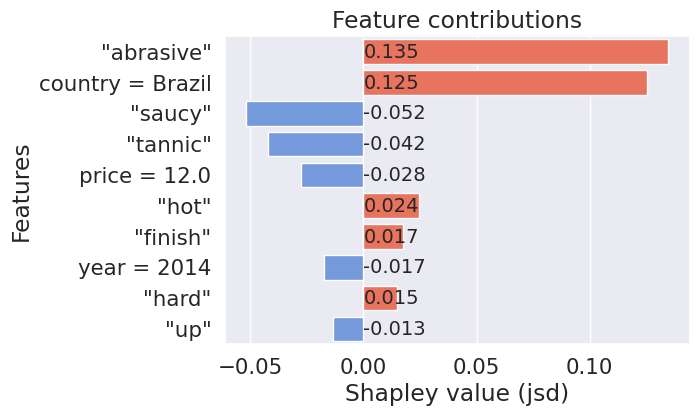

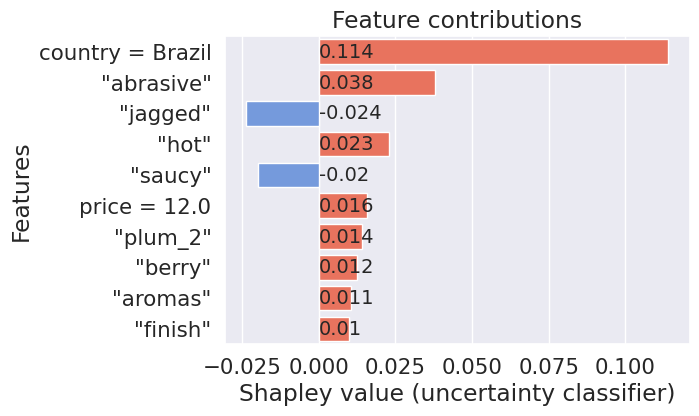

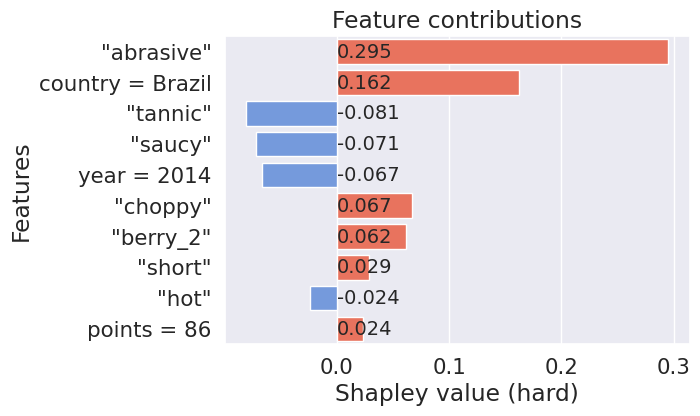

In [ ]:
# compute Shapley values
shapley_result, (jsd_std, uc_std, hard_std), (x_df, perturb_df), iter_conv = compute_Shapley(instance_to_explain = instance_to_explain,
                                                                                             base_dataset = Dc,
                                                                                             model = model,
                                                                                             value_function = rf_classifier,
                                                                                             cat_vars = categorical_var_oe,
                                                                                             num_vars = numerical_var_scaled,
                                                                                             token_var = "encoded_var",
                                                                                             words=words,
                                                                                             M = 50,
                                                                                             T = 10,
                                                                                             conv_eps = 0.01,
                                                                                             seed=SEED,
                                                                                             device=device,
                                                                                             display = True)

***Consistency with Kernel Shap***

In [ ]:
# compute the contribution with Kernl SHAP method
shapley_result = kernel_shap_consistency(perturb_df, x_df, shapley_result, seed=SEED)

In [ ]:
consistency_res_ks = pd.DataFrame()
consistency_res_ks.loc["jsd vs ks-jsd", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (jsd)"],shapley_result["Kernel Shap (jsd)"])
consistency_res_ks.loc["uncertainty classifier vs ks-uncertainty classifier", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (uncertainty classifier)"],shapley_result["Kernel Shap (uncertainty classifier)"])
consistency_res_ks.loc["hard vs ks-hard", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (hard)"],shapley_result["Kernel Shap (hard)"])
consistency_res_ks

,pearson correlation,pearson p-value,top 3+ intersection
jsd vs ks-jsd,0.93,1.614519e-15,2.0
uncertainty classifier vs ks-uncertainty classifier,0.86,1.189923e-10,2.0
hard vs ks-hard,0.47,5.282622e-03,2.0


**Synthetic example: example 2**

In [ ]:
## craft synthetic inputs by changing certain predictions ->  uncertain

# select certain instance
print("Before:")
instance_id = 213
instance_to_explain = Dc.loc[instance_id]
display(pd.DataFrame(instance_to_explain).T)

# before: compute softmax and jsd
x = instance_to_explain[categorical_var_oe + numerical_var_scaled + ["encoded_var"]]
y = instance_to_explain.Y
text = torch.tensor([x["encoded_var"]])
categorical = torch.tensor([x[categorical_var_oe]]).int()
numerical = torch.tensor([x[numerical_var_scaled]]).float()
label = torch.tensor([y]).int()
x_tensor = TensorDataset(text, categorical, numerical, label)
x_loader = DataLoader(x_tensor, batch_size = 1)
text_preds, text_softs, tabular_preds, tabular_softs, jsd, preds = value_function_jsd(x_loader, model, model_type = "TTT", seed = SEED, device = device)
uncert_clf_proba = rf_classifier.predict_proba(np.concatenate((text_softs,tabular_softs), axis=1))[:,1]

# craft example by changing price to min
print("After:")
numerical_var_scaled = [var + " - scaled" for var in numerical_var]
sc = StandardScaler()
df[numerical_var_scaled] = pd.DataFrame(sc.fit_transform(df[numerical_var]), columns = numerical_var_scaled).values
instance_to_explain.loc["price"] = Dc.loc[instance_id]['price']/2 # half price
instance_to_explain.loc["price - scaled"] = sc.transform(instance_to_explain[numerical_var].values.reshape(1, -1))[:,1][0]
x = instance_to_explain[categorical_var_oe + numerical_var_scaled + ["encoded_var"]]
y = instance_to_explain.Y

# convert to tensor and loader
text = torch.tensor([x["encoded_var"]])
categorical = torch.tensor([x[categorical_var_oe]]).int()
numerical = torch.tensor([x[numerical_var_scaled]]).float()
label = torch.tensor([y]).int()
x_tensor = TensorDataset(text, categorical, numerical, label)
x_loader = DataLoader(x_tensor, batch_size = 1)

# compute softmax and jsd
text_preds, text_softs, tabular_preds, tabular_softs, jsd, preds = value_function_jsd(x_loader, model, model_type = "TTT", seed = SEED, device = device)
uncert_clf_proba = rf_classifier.predict_proba(np.concatenate((text_softs,tabular_softs), axis=1))[:,1]

# add fields
instance_to_explain = instance_to_explain[categorical_var + numerical_var + [text_var] + ['Y', 'Variety'] + ["encoded_var"] + numerical_var_scaled + categorical_var_oe ]
instance_to_explain["preds"] = preds[0]
instance_to_explain["text_preds"] = text_preds[0]
instance_to_explain["tab_preds"] = tabular_preds[0]
instance_to_explain["jsd"] = jsd[0]
instance_to_explain["uncertainty_classifier"] = uncert_clf_proba[0]
display(pd.DataFrame(instance_to_explain).T)

Before:


,country,year,points,price,description,Y,Variety,encoded_var,points - scaled,price - scaled,country - oe,year - oe,p_text0,p_text1,p_text2,p_text3,p_text4,p_text5,p_text6,p_text7,p_text8,p_text9,p_text10,p_text11,p_text12,p_text13,p_text14,p_text15,p_text16,p_text17,p_text18,p_text19,p_text20,p_text21,p_text22,p_text23,p_text24,p_text25,p_text26,p_text27,p_text28,p_text29,p_text30,p_text31,p_text32,p_text33,p_text34,p_text35,p_text36,p_text37,p_text38,p_text39,p_text40,p_text41,p_text42,p_text43,p_text44,p_text45,p_text46,p_text47,p_text48,p_text49,p_text50,p_text51,p_text52,p_text53,p_text54,p_text55,p_text56,p_text57,p_text58,p_text59,p_text60,p_text61,p_text62,p_text63,p_text64,p_text65,p_text66,p_text67,p_text68,p_text69,p_text70,p_text71,p_text72,p_text73,p_text74,p_text75,p_text76,p_text77,p_text78,p_text79,p_text80,p_text81,p_text82,p_text83,p_text84,p_text85,p_text86,p_text87,p_text88,p_text89,p_text90,p_text91,p_text92,p_text93,p_text94,p_text95,p_text96,p_text97,p_text98,p_text99,p_tab0,p_tab1,p_tab2,p_tab3,p_tab4,p_tab5,p_tab6,p_tab7,p_tab8,p_tab9,p_tab10,p_tab11,p_tab12,p_tab13,p_tab14,p_tab15,p_tab16,p_tab17,p_tab18,p_tab19,p_tab20,p_tab21,p_tab22,p_tab23,p_tab24,p_tab25,p_tab26,p_tab27,p_tab28,p_tab29,p_tab30,p_tab31,p_tab32,p_tab33,p_tab34,p_tab35,p_tab36,p_tab37,p_tab38,p_tab39,p_tab40,p_tab41,p_tab42,p_tab43,p_tab44,p_tab45,p_tab46,p_tab47,p_tab48,p_tab49,p_tab50,p_tab51,p_tab52,p_tab53,p_tab54,p_tab55,p_tab56,p_tab57,p_tab58,p_tab59,p_tab60,p_tab61,p_tab62,p_tab63,p_tab64,p_tab65,p_tab66,p_tab67,p_tab68,p_tab69,p_tab70,p_tab71,p_tab72,p_tab73,p_tab74,p_tab75,p_tab76,p_tab77,p_tab78,p_tab79,p_tab80,p_tab81,p_tab82,p_tab83,p_tab84,p_tab85,p_tab86,p_tab87,p_tab88,p_tab89,p_tab90,p_tab91,p_tab92,p_tab93,p_tab94,p_tab95,p_tab96,p_tab97,p_tab98,p_tab99,preds,text_preds,tab_preds,jsd,is_uncertain,uncertainty_classifier
213,US,2008,85,42.0,"A little unripe, with some green, vegetal flav...",58,Pinot Noir,"[18, 959, 2341, 101, 183, 171, 1061, 17, 32, 2...",-1.137832,0.143409,39,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000011,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000017,0.0,0.0,0.000015,0.0,0.0,0.000767,0.014666,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000076,0.0,0.0,0.0,0.0,0.00022,0.0,0.0,0.0,0.000004,0.001724,0.0,0.0,0.0,0.000027,0.0,0.0,0.0,0.0,0.0,0.0,0.000007,0.0,0.0,0.0,0.0,0.0,0.971492,0.0,0.0,0.0,0.0,0.000009,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.006232,0.0,0.0,0.000238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004444,0.0,58,58,58,0.119501,0,0.0


After:


,country,year,points,price,description,Y,Variety,encoded_var,points - scaled,price - scaled,country - oe,year - oe,preds,text_preds,tab_preds,jsd,uncertainty_classifier
213,US,2008,85,21.0,"A little unripe, with some green, vegetal flav...",58,Pinot Noir,"[18, 959, 2341, 101, 183, 171, 1061, 17, 32, 2...",-1.137832,-0.348325,39,41,58,58,98,0.872923,0.5


In [ ]:
instance_to_explain.description

"A little unripe, with some green, vegetal flavors. But it's dry, and shows enough cherry and oak richness to satisfy. The mouthfeel is nice and silky."

iteration: 20 - shapley (hard) max abs difference: 0.25
iteration: 30 - shapley (hard) max abs difference: 0.117
iteration: 40 - shapley (hard) max abs difference: 0.1
iteration: 50 - shapley (hard) max abs difference: 0.075
iteration: 60 - shapley (hard) max abs difference: 0.04
iteration: 70 - shapley (hard) max abs difference: 0.069
iteration: 80 - shapley (hard) max abs difference: 0.068
iteration: 90 - shapley (hard) max abs difference: 0.042
iteration: 100 - shapley (hard) max abs difference: 0.041
iteration: 110 - shapley (hard) max abs difference: 0.018
iteration: 120 - shapley (hard) max abs difference: 0.034
iteration: 130 - shapley (hard) max abs difference: 0.037
iteration: 140 - shapley (hard) max abs difference: 0.021
iteration: 150 - shapley (hard) max abs difference: 0.014
iteration: 160 - shapley (hard) max abs difference: 0.022
iteration: 170 - shapley (hard) max abs difference: 0.015
iteration: 180 - shapley (hard) max abs difference: 0.019
iteration: 190 - shapley (

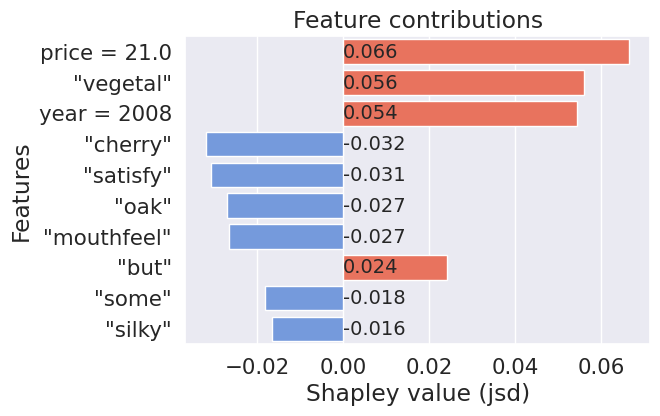

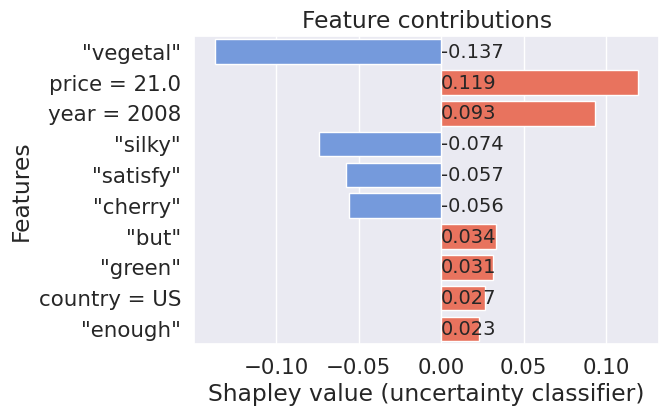

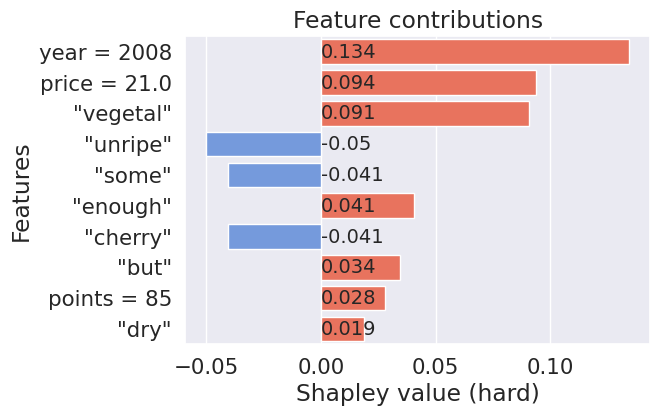

In [ ]:
# compute Shapley values
shapley_result, (jsd_std, uc_std, hard_std), (x_df, perturb_df), iter_conv = compute_Shapley(instance_to_explain = instance_to_explain,
                                                                                             base_dataset = Dc,
                                                                                             model = model,
                                                                                             value_function = rf_classifier,
                                                                                             cat_vars = categorical_var_oe,
                                                                                             num_vars = numerical_var_scaled,
                                                                                             token_var = "encoded_var",
                                                                                             words=words,
                                                                                             M = 50,
                                                                                             T = 10,
                                                                                             conv_eps = 0.01,
                                                                                             seed=SEED,
                                                                                             device=device,
                                                                                             display = True)

***Consistency with Kernel Shap***

In [ ]:
# compute the contribution with Kernel SHAP method
shapley_result = kernel_shap_consistency(perturb_df, x_df, shapley_result, seed=SEED)

In [ ]:
consistency_res_ks = pd.DataFrame()
consistency_res_ks.loc["jsd vs ks-jsd", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (jsd)"],shapley_result["Kernel Shap (jsd)"])
consistency_res_ks.loc["uncertainty classifier vs ks-uncertainty classifier", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (uncertainty classifier)"],shapley_result["Kernel Shap (uncertainty classifier)"])
consistency_res_ks.loc["hard vs ks-hard", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (hard)"],shapley_result["Kernel Shap (hard)"])
consistency_res_ks

,pearson correlation,pearson p-value,top 3+ intersection
jsd vs ks-jsd,0.39,2.805229e-02,1.0
uncertainty classifier vs ks-uncertainty classifier,0.88,3.988868e-11,2.0
hard vs ks-hard,0.64,9.923864e-05,2.0


**OOD instance**

In [ ]:
# load instances from classes that are not included in wine_100: OOD

# load data
ood_df = pd.read_csv("datasets/" + FILENAME)
# rename label
ood_df["Variety"] = ood_df["variety"].copy()
ood_df = ood_df.rename({"variety":"Y"}, axis=1)
# extract year from title
yearSearch = []
for value in ood_df['title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult:
        yearSearch.append(regexresult.group())
    else:
        yearSearch.append(None)
ood_df['year'] = yearSearch
# drop unused columns
ood_df = ood_df[categorical_var + numerical_var + [text_var, 'Y', 'Variety']]
# drop na
ood_df = ood_df.dropna().reset_index(drop=True)
# label Y: keep only classes after 100
ood_df = ood_df[ood_df.Y.isin(ood_df['Y'].value_counts(ascending=False).index[N_CLASSES:].tolist())]
# label encoding of target variable
le = LabelEncoder()
ood_df['Y'] = le.fit_transform(ood_df['Y'])+N_CLASSES
# encode text
ood_df['encoded_var'] = ood_df[text_var].apply(lambda x: encode_sentence(x,vocab2index,max_len=MAX_LEN))
# Numerical variables pre-processing
numerical_var_scaled = standardScaling(df, ood_df, numerical_var)
# Categorical variables pre-processing
categorical_var_oe, CAT_VOCAB_SIZES = ordinalEncoding(df, ood_df, categorical_var)

# create data loader
dataset_ood = CustomDataset(
                            texts = ood_df['encoded_var'].values,
                            categoricals = ood_df[categorical_var_oe],
                            numericals = ood_df[numerical_var_scaled],
                            labels = ood_df['Y'].values)

loader_ood = DataLoader(dataset_ood, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
# select uncertain predictions (Du)

# compute Jensen Shannon Divergence between text and tabular softmax distributions (value function#1)
text_preds, text_softs, tabular_preds, tabular_softs, jsd, preds = value_function_jsd(loader_ood, model, model_type = MODEL_TYPE, seed = SEED, device = device)
data_ood = ood_df.reset_index(drop=True)
p_text = ["p_text"+str(i) for i in range(text_softs.shape[1])]
p_tab = ["p_tab"+str(i) for i in range(tabular_softs.shape[1])]
data_ood[p_text] = text_softs
data_ood[p_tab] = tabular_softs
data_ood["preds"] = preds
data_ood["text_preds"] = text_preds
data_ood["tab_preds"] = tabular_preds
data_ood["jsd"] = jsd

# compute uncertainty
data_ood["is_uncertain"] = (data_ood["text_preds"]!=data_ood["tab_preds"]).astype(int)

# split dataset into certain and uncertain
Du_ood = data_ood[data_ood["is_uncertain"]==1].copy()

# add uncertainty classifier prediction
Du_ood["uncertainty_classifier"]=rf_classifier.predict_proba(Du_ood[p_text+p_tab])[:,1]

In [ ]:
# select incertain instance
instance_id = 2325
instance_to_explain = Du_ood.loc[instance_id]
display(pd.DataFrame(instance_to_explain).T)

,country,year,points,price,description,Y,Variety,encoded_var,points - scaled,price - scaled,country - oe,year - oe,p_text0,p_text1,p_text2,p_text3,p_text4,p_text5,p_text6,p_text7,p_text8,p_text9,p_text10,p_text11,p_text12,p_text13,p_text14,p_text15,p_text16,p_text17,p_text18,p_text19,p_text20,p_text21,p_text22,p_text23,p_text24,p_text25,p_text26,p_text27,p_text28,p_text29,p_text30,p_text31,p_text32,p_text33,p_text34,p_text35,p_text36,p_text37,p_text38,p_text39,p_text40,p_text41,p_text42,p_text43,p_text44,p_text45,p_text46,p_text47,p_text48,p_text49,p_text50,p_text51,p_text52,p_text53,p_text54,p_text55,p_text56,p_text57,p_text58,p_text59,p_text60,p_text61,p_text62,p_text63,p_text64,p_text65,p_text66,p_text67,p_text68,p_text69,p_text70,p_text71,p_text72,p_text73,p_text74,p_text75,p_text76,p_text77,p_text78,p_text79,p_text80,p_text81,p_text82,p_text83,p_text84,p_text85,p_text86,p_text87,p_text88,p_text89,p_text90,p_text91,p_text92,p_text93,p_text94,p_text95,p_text96,p_text97,p_text98,p_text99,p_tab0,p_tab1,p_tab2,p_tab3,p_tab4,p_tab5,p_tab6,p_tab7,p_tab8,p_tab9,p_tab10,p_tab11,p_tab12,p_tab13,p_tab14,p_tab15,p_tab16,p_tab17,p_tab18,p_tab19,p_tab20,p_tab21,p_tab22,p_tab23,p_tab24,p_tab25,p_tab26,p_tab27,p_tab28,p_tab29,p_tab30,p_tab31,p_tab32,p_tab33,p_tab34,p_tab35,p_tab36,p_tab37,p_tab38,p_tab39,p_tab40,p_tab41,p_tab42,p_tab43,p_tab44,p_tab45,p_tab46,p_tab47,p_tab48,p_tab49,p_tab50,p_tab51,p_tab52,p_tab53,p_tab54,p_tab55,p_tab56,p_tab57,p_tab58,p_tab59,p_tab60,p_tab61,p_tab62,p_tab63,p_tab64,p_tab65,p_tab66,p_tab67,p_tab68,p_tab69,p_tab70,p_tab71,p_tab72,p_tab73,p_tab74,p_tab75,p_tab76,p_tab77,p_tab78,p_tab79,p_tab80,p_tab81,p_tab82,p_tab83,p_tab84,p_tab85,p_tab86,p_tab87,p_tab88,p_tab89,p_tab90,p_tab91,p_tab92,p_tab93,p_tab94,p_tab95,p_tab96,p_tab97,p_tab98,p_tab99,preds,text_preds,tab_preds,jsd,is_uncertain,uncertainty_classifier
2325,Italy,2005,91,75.0,This floral wine is bursting with notes of jas...,611,Tocai Friulano,"[39, 454, 62, 40, 1267, 101, 478, 3, 1580, 10,...",0.824458,0.916134,21,38,0.00001,0.0,0.0,0.000895,0.000095,0.0,0.0,0.000011,0.000001,0.000001,0.000021,0.000001,0.000016,0.0,0.0,0.0,0.000094,0.002874,0.000001,0.000123,0.000011,0.317849,0.000529,0.000699,0.0,0.001856,0.000052,0.006684,0.028982,0.000001,0.038447,0.000357,0.000001,0.001093,0.0,0.000004,0.0,0.0,0.000003,0.0,0.000003,0.000397,0.0,0.00225,0.091851,0.000223,0.001495,0.112466,0.000015,0.007993,0.000003,0.000001,0.0,0.005358,0.000002,0.006887,0.000011,0.196704,0.000026,0.0,0.000002,0.0,0.0,0.000012,0.018218,0.000014,0.000001,0.001458,0.000269,0.000002,0.000152,0.00096,0.000058,0.000001,0.03932,0.000001,0.000429,0.0,0.0,0.014062,0.0,0.000062,0.000054,0.0,0.000004,0.000003,0.0,0.0,0.0,0.0,0.000079,0.0,0.019793,0.004134,0.003777,0.000014,0.000001,0.070725,0.0,0.0,0.004923,0.0,0.000001,0.00083,0.019712,0.0,0.0,0.0,0.0,0.000001,0.0,0.000185,0.000001,0.0,0.0,0.0,0.000002,0.000117,0.000002,0.104338,0.001836,0.004753,0.000597,0.000009,0.0,0.091881,0.000024,0.001989,0.000438,0.0,0.004422,0.000025,0.0,0.002793,0.000078,0.003327,0.0,0.0,0.0,0.0,0.0,0.000842,0.0,0.186683,0.027522,0.0,0.000012,0.000058,0.024422,0.020329,0.081471,0.000039,0.000004,0.000069,0.0,0.001122,0.0,0.009979,0.000003,0.0,0.000001,0.000014,0.00011,0.11386,0.089512,0.0,0.0,0.002153,0.000009,0.0,0.003896,0.00207,0.000006,0.000355,0.015512,0.000758,0.000012,0.000007,0.000083,0.000966,0.0,0.009694,0.0,0.0,0.000049,0.000001,0.0,0.0,0.0,0.0,0.003325,0.0,0.042972,0.007601,0.025191,0.000256,0.000007,0.086564,0.000175,0.000001,97,21,43,0.818378,1,0.84


In [ ]:
instance_to_explain.description

'This floral wine is bursting with notes of jasmine and honeysuckle backed by sweet fragrances of candied fruit and caramel. The wine is sweet and thick in the mouth but the well-dosed acidity keeps it from being cloying or too fat. It would pair well with slightly sweet foods such as honey glazed ham or lobster.'

iteration: 20 - shapley (hard) max abs difference: 0.25
iteration: 30 - shapley (hard) max abs difference: 0.1
iteration: 40 - shapley (hard) max abs difference: 0.083
iteration: 50 - shapley (hard) max abs difference: 0.04
iteration: 60 - shapley (hard) max abs difference: 0.043
iteration: 70 - shapley (hard) max abs difference: 0.038
iteration: 80 - shapley (hard) max abs difference: 0.045
iteration: 90 - shapley (hard) max abs difference: 0.032
iteration: 100 - shapley (hard) max abs difference: 0.027
iteration: 110 - shapley (hard) max abs difference: 0.021
iteration: 120 - shapley (hard) max abs difference: 0.029
iteration: 130 - shapley (hard) max abs difference: 0.018
iteration: 140 - shapley (hard) max abs difference: 0.015
iteration: 150 - shapley (hard) max abs difference: 0.015
iteration: 160 - shapley (hard) max abs difference: 0.016
iteration: 170 - shapley (hard) max abs difference: 0.017
iteration: 180 - shapley (hard) max abs difference: 0.015
iteration: 190 - shapley (

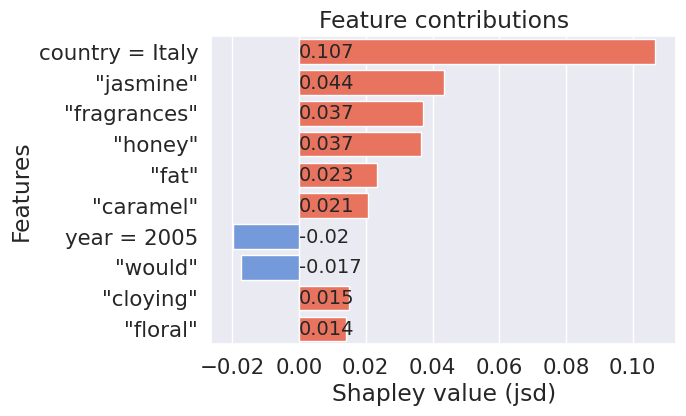

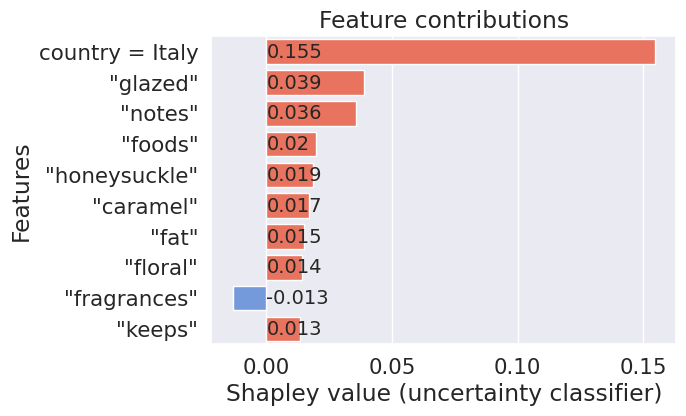

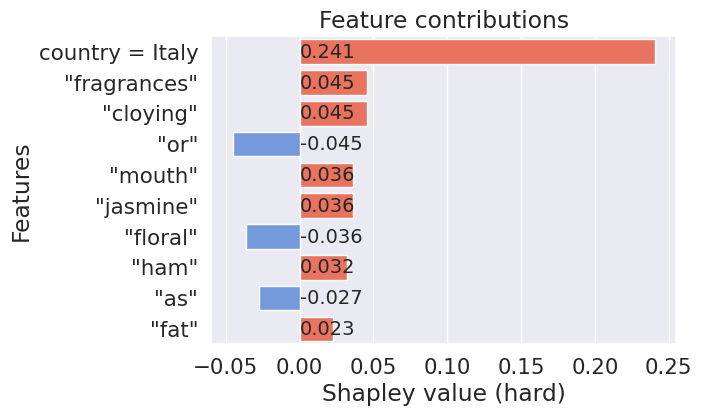

In [ ]:
# compute Shapley values
shapley_result, (jsd_std, uc_std, hard_std), (x_df, perturb_df), iter_conv = compute_Shapley(instance_to_explain = instance_to_explain,
                                                                                             base_dataset = Dc,
                                                                                             model = model,
                                                                                             value_function = rf_classifier,
                                                                                             cat_vars = categorical_var_oe,
                                                                                             num_vars = numerical_var_scaled,
                                                                                             token_var = "encoded_var",
                                                                                             words=words,
                                                                                             M = 50,
                                                                                             T = 10,
                                                                                             conv_eps = 0.01,
                                                                                             seed=SEED,
                                                                                             device=device,
                                                                                             display = True)

**Consistency with Kernel Shap**

In [ ]:
# compute the contribution with Kernl SHAP method
shapley_result = kernel_shap_consistency(perturb_df, x_df, shapley_result, seed=SEED)

In [ ]:
consistency_res_ks = pd.DataFrame()
consistency_res_ks.loc["jsd vs ks-jsd", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (jsd)"],shapley_result["Kernel Shap (jsd)"])
consistency_res_ks.loc["uncertainty classifier vs ks-uncertainty classifier", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (uncertainty classifier)"],shapley_result["Kernel Shap (uncertainty classifier)"])
consistency_res_ks.loc["hard vs ks-hard", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (hard)"],shapley_result["Kernel Shap (hard)"])
consistency_res_ks

,pearson correlation,pearson p-value,top 3+ intersection
jsd vs ks-jsd,0.68,3.066035e-09,1.0
uncertainty classifier vs ks-uncertainty classifier,0.89,2.947470e-21,1.0
hard vs ks-hard,0.84,4.906518e-17,1.0


### **Explaining uncertainty: cloth dataset**

In [ ]:
# select dataset and seed to compute Shapley values
DATASET = "cloth"
set_seed = 0
PATIENCE = 4

# load settings
FILENAME, categorical_var, numerical_var, text_var, MAX_LEN_QUANTILE, N_CLASSES, WEIGHT_DECAY, FACTOR, N_EPOCHS, split_val, CRITERION, N_SEED, DROPOUT= load_settings(dataset = DATASET)

perf_results = pd.DataFrame()
i = 0

SEED = set_seed
MODEL_TYPE = "TTT"

start = time.time()
perf_results.loc[i,"seed"] = SEED
perf_results.loc[i,"model type"] = MODEL_TYPE

# GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load and prepare dataset
df = preprocess_dataset(DATASET, MODEL_TYPE)

# Train/Test split
df, target = train_test_split(df, test_size = split_val, random_state = SEED)

# text max length
MAX_LEN = int(np.quantile(df.apply(lambda row : len(row[text_var].split()), axis=1).values, q = [MAX_LEN_QUANTILE]).item())
perf_results.loc[i,"max text length"] = MAX_LEN

# vocabulary construction
vocab2index, VOCAB_SIZE, words = vocabulary(df, text_field = text_var)
perf_results.loc[i,"vocab size"] = VOCAB_SIZE

# encode text on Source and Target
df['encoded_var'] = df[text_var].apply(lambda x: encode_sentence(x,vocab2index,max_len=MAX_LEN))
target['encoded_var'] = target[text_var].apply(lambda x: encode_sentence(x,vocab2index,max_len=MAX_LEN))

# Numerical variables pre-processing
numerical_var_scaled = standardScaling(df, target, numerical_var)
QUANTILES = []
for var in numerical_var_scaled:
    QUANTILES.append(np.quantile(df[var].values, q = [0., 0.2, 0.4, 0.6, 0.8, 1.]))

NUM_NUMERICAL_VAR = len(numerical_var)

# Categorical variables pre-processing
if MODEL_TYPE in ["LateFuse", "TFN"]:
    categorical_var_oe = oneHotEncoding(df, target, categorical_var)
    NUM_CAT_VAR = len(categorical_var_oe)
    CAT_VOCAB_SIZES = None
else:
    categorical_var_oe, CAT_VOCAB_SIZES = ordinalEncoding(df, target, categorical_var)
    NUM_CAT_VAR = len(categorical_var)

# train / validation split
df_train, df_validation = train_test_split(df, test_size = split_val, random_state = SEED)
perf_results.loc[i,"training size"] = df_train.shape[0]
perf_results.loc[i,"test size"] = target.shape[0]

# prepare custom datasets
dataset_train, dataset_validation, dataset_target = prepareCustomDatasets(df_train, df_validation, target,
                                                                      encoded_text_var = 'encoded_var',
                                                                      categorical_var = categorical_var_oe,
                                                                      numerical_var = numerical_var_scaled,
                                                                      label = 'Y')

# import hyper-parameters from Bayesian Optimization (directory perf_results/)
res = pd.read_csv("results/"+DATASET+"_perf_results.csv")
res = res[(res["model type"]=="TTT") & (res["seed"]==SEED)]
LR, BATCH_SIZE, D_MODEL, N_LAYERS, N_HEADS = res[["LR",	"BATCH_SIZE",	"D_MODEL",	"N_LAYERS",	"N_HEADS"]].values[0]
LR, BATCH_SIZE, D_MODEL, N_LAYERS, N_HEADS = LR, int(BATCH_SIZE), int(D_MODEL), int(N_LAYERS), int(N_HEADS)

# same dimension for Feed Forward and Fully Connected
D_FF = D_MODEL
D_FC = D_MODEL

perf_results.loc[i,"LR"] = LR
perf_results.loc[i,"BATCH_SIZE"] = BATCH_SIZE
perf_results.loc[i,"D_MODEL"] = D_MODEL
perf_results.loc[i,"N_LAYERS"] = N_LAYERS
perf_results.loc[i,"N_HEADS"] = N_HEADS

# create loaders: training + validation (Source) and Target
loader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True)
loader_validation = DataLoader(dataset_validation, batch_size = BATCH_SIZE, shuffle = True)
loader_target = DataLoader(dataset_target, batch_size = BATCH_SIZE)

# model initialization
model = init_model(model_type = MODEL_TYPE,
                    d_model = D_MODEL,
                    max_len = MAX_LEN,
                    vocab_size = VOCAB_SIZE,
                    cat_vocab_sizes = CAT_VOCAB_SIZES,
                    num_cat_var = NUM_CAT_VAR,
                    num_numerical_var = NUM_NUMERICAL_VAR,
                    quantiles = QUANTILES,
                    n_heads = N_HEADS,
                    d_ff = D_FF,
                    n_layers = N_LAYERS,
                    dropout = DROPOUT,
                    d_fc = D_FC,
                    n_classes = N_CLASSES,
                    seed = SEED,
                    device=device).to(device)

# number of trainable parameters
perf_results.loc[i,"trainable parameters"] = sum(p.numel() for p in model.parameters() if p.requires_grad)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# training or load checkpoint
model = training(model, loader_train,  N_EPOCHS, loader_validation, CRITERION, optimizer, PATIENCE, FACTOR, MODEL_TYPE, SEED, verbose=False, device = device, early_stopping = True)

# model evaluation and uncertainty quantification
model.eval()

# target
perf, labels, preds, text_preds, tabular_preds = performance(model, loader_target, MODEL_TYPE, SEED, device)
perf_results.loc[i,"performance"] = perf

elapsed_time = time.time()-start
perf_results.loc[i,"time"] = elapsed_time

i+=1

display(perf_results)



,seed,model type,max text length,vocab size,training size,test size,LR,BATCH_SIZE,D_MODEL,N_LAYERS,N_HEADS,trainable parameters,performance,time
0,0.0,TTT,102.0,7502.0,14481.0,4526.0,0.000364,32.0,64.0,3.0,4.0,643338.0,0.646487,203.982078


**Construct Dc, Du, and value functions**

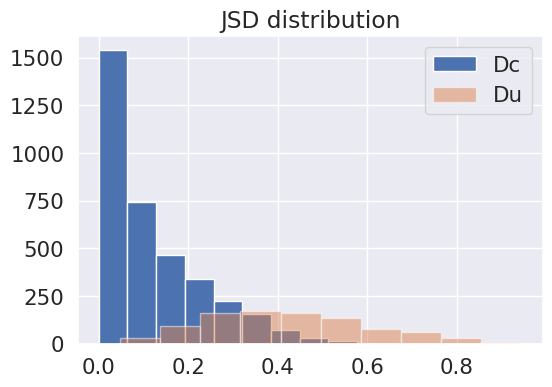

In [ ]:
## Construct Du and Dc: datasets with certain and uncertain predictions

# compute Jensen Shannon Divergence between text and tabular softmax distributions (value function#1)
text_preds, text_softs, tabular_preds, tabular_softs, jsd, preds = value_function_jsd(loader_target, model, model_type = MODEL_TYPE, seed = SEED, device = device)
data = target.reset_index(drop=True)
p_text = ["p_text"+str(i) for i in range(text_softs.shape[1])]
p_tab = ["p_tab"+str(i) for i in range(tabular_softs.shape[1])]
data[p_text] = text_softs
data[p_tab] = tabular_softs
data["preds"] = preds
data["text_preds"] = text_preds
data["tab_preds"] = tabular_preds
data["jsd"] = jsd

# compute uncertainty
data["is_uncertain"] = (data.text_preds!=data.tab_preds).astype(int)

# split dataset into certain and uncertain
Dc = data[data["is_uncertain"]==0].copy()
Du = data[data["is_uncertain"]==1].copy()

# jsd distribution for Du and Dc
plt.title("JSD distribution")
Dc["jsd"].hist(density = False, figsize = (6,4) )
Du["jsd"].hist(density = False, alpha = 0.5, figsize = (6,4))
plt. legend(['Dc', 'Du'])

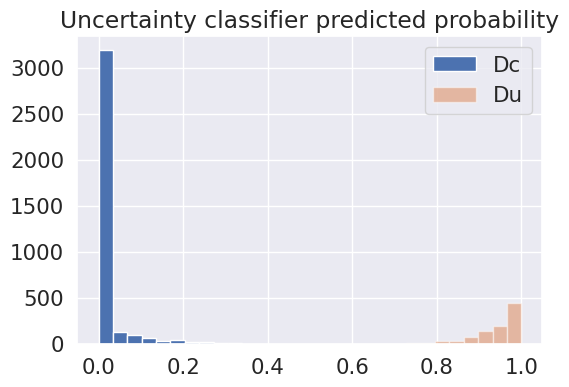

In [ ]:
# value function#2: uncertainty classifier
rf_classifier = uncertainty_classifier(X=data[p_text+p_tab], y=data["is_uncertain"], seed= SEED)

# add uncertainty classifier prediction in Dc and Du
plt.title("Uncertainty classifier predicted probability")
Dc["uncertainty_classifier"]=rf_classifier.predict_proba(Dc[p_text+p_tab])[:,1]
Du["uncertainty_classifier"]=rf_classifier.predict_proba(Du[p_text+p_tab])[:,1]
Dc["uncertainty_classifier"].hist(density = False, figsize = (6,4) )
Du["uncertainty_classifier"].hist(density = False, alpha = 0.5, figsize = (6,4))
plt. legend(['Dc', 'Du'])

**Uncertain prediction: example**

In [ ]:
# select uncertain instance
instance_id = 563
instance_to_explain = Du.loc[instance_id]
display(pd.DataFrame(instance_to_explain).T)

,Division Name,Department Name,Class Name,Age,Positive Feedback Count,Review,Y,encoded_var,Age - scaled,Positive Feedback Count - scaled,Division Name - oe,Department Name - oe,Class Name - oe,p_text0,p_text1,p_text2,p_text3,p_text4,p_tab0,p_tab1,p_tab2,p_tab3,p_tab4,preds,text_preds,tab_preds,jsd,is_uncertain,uncertainty_classifier
563,General,Bottoms,Shorts,43,0,Romper rules Overall great romper! i have a lo...,3,"[252, 5651, 270, 33, 252, 23, 100, 27, 371, 12...",-0.023751,-0.454531,1,1,15,0.000074,0.000238,0.004653,0.031376,0.963659,0.000012,0.000007,0.001553,0.897,0.101427,4,4,3,0.810501,1,1.0


In [ ]:
instance_to_explain.Review

'Romper rules Overall great romper! i have a long torso and thicker legs so i sized up to a small and i am very happy i did. the shorts are a bit on the shorter side and go upon the sides so another reason to consider sizing up. the quality is great and super soft chambray with a trendy tie up.'

iteration: 20 - shapley (hard) max abs difference: 0.15
iteration: 30 - shapley (hard) max abs difference: 0.1
iteration: 40 - shapley (hard) max abs difference: 0.092
iteration: 50 - shapley (hard) max abs difference: 0.055
iteration: 60 - shapley (hard) max abs difference: 0.043
iteration: 70 - shapley (hard) max abs difference: 0.06
iteration: 80 - shapley (hard) max abs difference: 0.032
iteration: 90 - shapley (hard) max abs difference: 0.031
iteration: 100 - shapley (hard) max abs difference: 0.021
iteration: 110 - shapley (hard) max abs difference: 0.035
iteration: 120 - shapley (hard) max abs difference: 0.014
iteration: 130 - shapley (hard) max abs difference: 0.018
iteration: 140 - shapley (hard) max abs difference: 0.013
iteration: 150 - shapley (hard) max abs difference: 0.019
iteration: 160 - shapley (hard) max abs difference: 0.017
iteration: 170 - shapley (hard) max abs difference: 0.011
iteration: 180 - shapley (hard) max abs difference: 0.018
iteration: 190 - shapley (

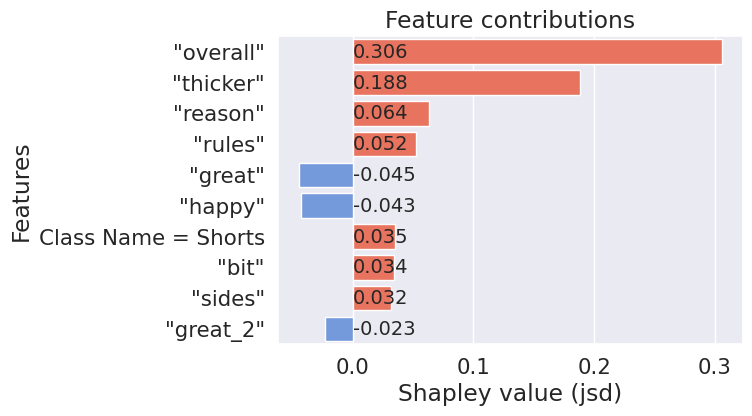

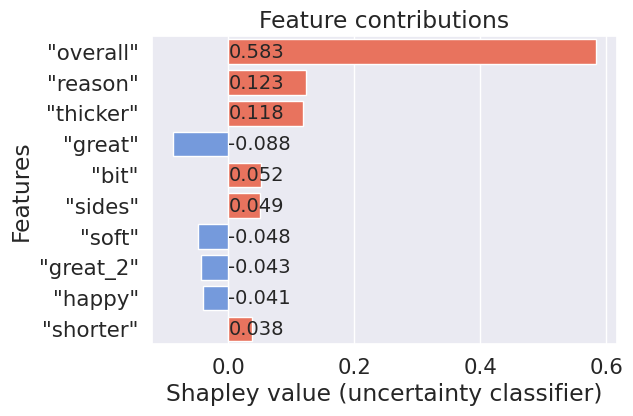

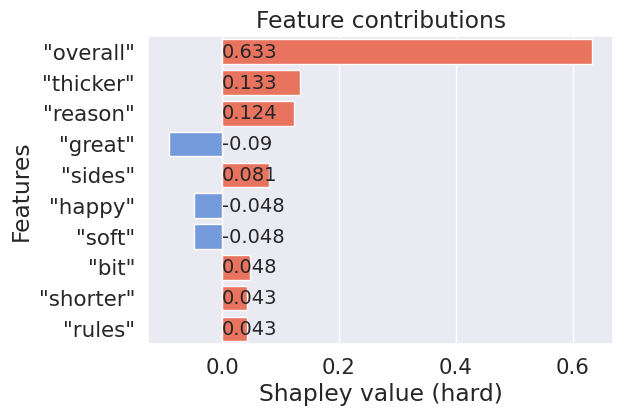

In [ ]:
# compute Shapley values
shapley_result, (jsd_std, uc_std, hard_std), (x_df, perturb_df), iter_conv = compute_Shapley(instance_to_explain = instance_to_explain,
                                                                                             base_dataset = Dc,
                                                                                             model = model,
                                                                                             value_function = rf_classifier,
                                                                                             cat_vars = categorical_var_oe,
                                                                                             num_vars = numerical_var_scaled,
                                                                                             token_var = "encoded_var",
                                                                                             words=words,
                                                                                             M = 50,
                                                                                             T = 10,
                                                                                             conv_eps = 0.01,
                                                                                             seed=SEED,
                                                                                             device=device,
                                                                                             display = True)

***Consistency with Kernel Shap***

In [ ]:
# compute the contribution with Kernl SHAP method
shapley_result = kernel_shap_consistency(perturb_df, x_df, shapley_result, seed=SEED)

In [ ]:
consistency_res_ks = pd.DataFrame()
consistency_res_ks.loc["jsd vs ks-jsd", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (jsd)"],shapley_result["Kernel Shap (jsd)"])
consistency_res_ks.loc["uncertainty classifier vs ks-uncertainty classifier", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (uncertainty classifier)"],shapley_result["Kernel Shap (uncertainty classifier)"])
consistency_res_ks.loc["hard vs ks-hard", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (hard)"],shapley_result["Kernel Shap (hard)"])
consistency_res_ks

,pearson correlation,pearson p-value,top 3+ intersection
jsd vs ks-jsd,0.90,9.688035e-25,2.0
uncertainty classifier vs ks-uncertainty classifier,0.93,1.136132e-28,1.0
hard vs ks-hard,0.72,9.963985e-12,1.0


### **Explaining uncertainty: kick dataset**

In [6]:
# select dataset and seed to compute Shapley values
DATASET = "kick"
set_seed = 0
PATIENCE = 4

# load settings
FILENAME, categorical_var, numerical_var, text_var, MAX_LEN_QUANTILE, N_CLASSES, WEIGHT_DECAY, FACTOR, N_EPOCHS, split_val, CRITERION, N_SEED, DROPOUT= load_settings(dataset = DATASET)

perf_results = pd.DataFrame()
i = 0

SEED = set_seed
MODEL_TYPE = "TTT"

start = time.time()
perf_results.loc[i,"seed"] = SEED
perf_results.loc[i,"model type"] = MODEL_TYPE

# GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load and prepare dataset
df = preprocess_dataset(DATASET, MODEL_TYPE)

# Train/Test split
df, target = train_test_split(df, test_size = split_val, random_state = SEED)

# text max length
MAX_LEN = int(np.quantile(df.apply(lambda row : len(row[text_var].split()), axis=1).values, q = [MAX_LEN_QUANTILE]).item())
perf_results.loc[i,"max text length"] = MAX_LEN

# vocabulary construction
vocab2index, VOCAB_SIZE, words = vocabulary(df, text_field = text_var)
perf_results.loc[i,"vocab size"] = VOCAB_SIZE

# encode text on Source and Target
df['encoded_var'] = df[text_var].apply(lambda x: encode_sentence(x,vocab2index,max_len=MAX_LEN))
target['encoded_var'] = target[text_var].apply(lambda x: encode_sentence(x,vocab2index,max_len=MAX_LEN))

# Numerical variables pre-processing
numerical_var_scaled = standardScaling(df, target, numerical_var)
QUANTILES = []
for var in numerical_var_scaled:
    QUANTILES.append(np.quantile(df[var].values, q = [0., 0.2, 0.4, 0.6, 0.8, 1.]))

NUM_NUMERICAL_VAR = len(numerical_var)

# Categorical variables pre-processing
if MODEL_TYPE in ["LateFuse", "TFN"]:
    categorical_var_oe = oneHotEncoding(df, target, categorical_var)
    NUM_CAT_VAR = len(categorical_var_oe)
    CAT_VOCAB_SIZES = None
else:
    categorical_var_oe, CAT_VOCAB_SIZES = ordinalEncoding(df, target, categorical_var)
    NUM_CAT_VAR = len(categorical_var)

# train / validation split
df_train, df_validation = train_test_split(df, test_size = split_val, random_state = SEED)
perf_results.loc[i,"training size"] = df_train.shape[0]
perf_results.loc[i,"test size"] = target.shape[0]

# prepare custom datasets
dataset_train, dataset_validation, dataset_target = prepareCustomDatasets(df_train, df_validation, target,
                                                                      encoded_text_var = 'encoded_var',
                                                                      categorical_var = categorical_var_oe,
                                                                      numerical_var = numerical_var_scaled,
                                                                      label = 'Y')

# import hyper-parameters from Bayesian Optimization (directory perf_results/)
res = pd.read_csv("results/"+DATASET+"_perf_results.csv")
res = res[(res["model type"]=="TTT") & (res["seed"]==SEED)]
LR, BATCH_SIZE, D_MODEL, N_LAYERS, N_HEADS = res[["LR",	"BATCH_SIZE",	"D_MODEL",	"N_LAYERS",	"N_HEADS"]].values[0]
LR, BATCH_SIZE, D_MODEL, N_LAYERS, N_HEADS = LR, int(BATCH_SIZE), int(D_MODEL), int(N_LAYERS), int(N_HEADS)

# same dimension for Feed Forward and Fully Connected
D_FF = D_MODEL
D_FC = D_MODEL

perf_results.loc[i,"LR"] = LR
perf_results.loc[i,"BATCH_SIZE"] = BATCH_SIZE
perf_results.loc[i,"D_MODEL"] = D_MODEL
perf_results.loc[i,"N_LAYERS"] = N_LAYERS
perf_results.loc[i,"N_HEADS"] = N_HEADS

# create loaders: training + validation (Source) and Target
loader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True)
loader_validation = DataLoader(dataset_validation, batch_size = BATCH_SIZE, shuffle = True)
loader_target = DataLoader(dataset_target, batch_size = BATCH_SIZE)

# model initialization
model = init_model(model_type = MODEL_TYPE,
                    d_model = D_MODEL,
                    max_len = MAX_LEN,
                    vocab_size = VOCAB_SIZE,
                    cat_vocab_sizes = CAT_VOCAB_SIZES,
                    num_cat_var = NUM_CAT_VAR,
                    num_numerical_var = NUM_NUMERICAL_VAR,
                    quantiles = QUANTILES,
                    n_heads = N_HEADS,
                    d_ff = D_FF,
                    n_layers = N_LAYERS,
                    dropout = DROPOUT,
                    d_fc = D_FC,
                    n_classes = N_CLASSES,
                    seed = SEED,
                    device=device).to(device)

# number of trainable parameters
perf_results.loc[i,"trainable parameters"] = sum(p.numel() for p in model.parameters() if p.requires_grad)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# training or load checkpoint
model = training(model, loader_train,  N_EPOCHS, loader_validation, CRITERION, optimizer, PATIENCE, FACTOR, MODEL_TYPE, SEED, verbose=False, device = device, early_stopping = True)

# model evaluation and uncertainty quantification
model.eval()

# target
perf, labels, preds, text_preds, tabular_preds = performance(model, loader_target, MODEL_TYPE, SEED, device)
perf_results.loc[i,"performance"] = perf

elapsed_time = time.time()-start
perf_results.loc[i,"time"] = elapsed_time

i+=1

display(perf_results)



,seed,model type,max text length,vocab size,training size,test size,LR,BATCH_SIZE,D_MODEL,N_LAYERS,N_HEADS,trainable parameters,performance,time
0,0.0,TTT,32.0,42860.0,69195.0,21624.0,0.00036,128.0,32.0,2.0,8.0,1401028.0,0.867601,294.728739


**Construct Dc, Du, and value functions**

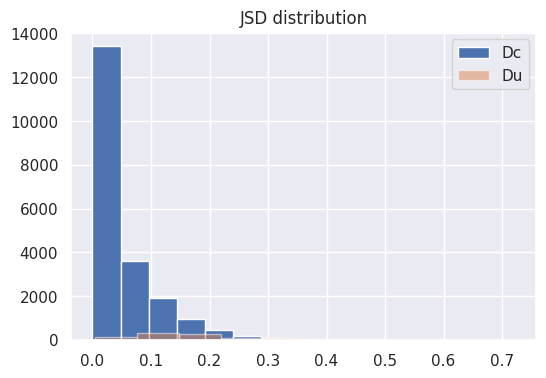

In [7]:
## Construct Du and Dc: datasets with certain and uncertain predictions

# compute Jensen Shannon Divergence between text and tabular softmax distributions (value function#1)
text_preds, text_softs, tabular_preds, tabular_softs, jsd, preds = value_function_jsd(loader_target, model, model_type = MODEL_TYPE, seed = SEED, device = device)
data = target.reset_index(drop=True)
p_text = ["p_text"+str(i) for i in range(text_softs.shape[1])]
p_tab = ["p_tab"+str(i) for i in range(tabular_softs.shape[1])]
data[p_text] = text_softs
data[p_tab] = tabular_softs
data["preds"] = preds
data["text_preds"] = text_preds
data["tab_preds"] = tabular_preds
data["jsd"] = jsd

# compute uncertainty
data["is_uncertain"] = (data.text_preds!=data.tab_preds).astype(int)

# split dataset into certain and uncertain
Dc = data[data["is_uncertain"]==0].copy()
Du = data[data["is_uncertain"]==1].copy()

# jsd distribution for Du and Dc
plt.title("JSD distribution")
Dc["jsd"].hist(density = False, figsize = (6,4) )
Du["jsd"].hist(density = False, alpha = 0.5, figsize = (6,4))
plt. legend(['Dc', 'Du'])

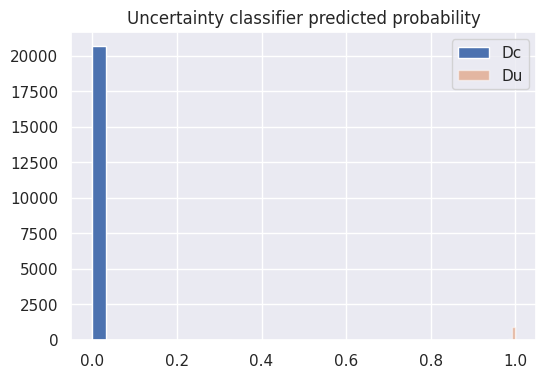

In [8]:
# value function#2: uncertainty classifier
rf_classifier = uncertainty_classifier(X=data[p_text+p_tab], y=data["is_uncertain"], seed= SEED)

# add uncertainty classifier prediction in Dc and Du
plt.title("Uncertainty classifier predicted probability")
Dc["uncertainty_classifier"]=rf_classifier.predict_proba(Dc[p_text+p_tab])[:,1]
Du["uncertainty_classifier"]=rf_classifier.predict_proba(Du[p_text+p_tab])[:,1]
Dc["uncertainty_classifier"].hist(density = False, figsize = (6,4) )
Du["uncertainty_classifier"].hist(density = False, alpha = 0.5, figsize = (6,4))
plt. legend(['Dc', 'Du'])

**Uncertain prediction: example**

In [9]:
# select uncertain instance
instance_id = 3691
instance_to_explain = Du.loc[instance_id]
display(pd.DataFrame(instance_to_explain).T)

,country,currency,disable_communication,log_goal,backers_count,duration,description,Y,encoded_var,log_goal - scaled,backers_count - scaled,duration - scaled,country - oe,currency - oe,disable_communication - oe,p_text0,p_text1,p_tab0,p_tab1,preds,text_preds,tab_preds,jsd,is_uncertain,uncertainty_classifier
3691,US,USD,False,4.0,447,29.958333,The Life & Times of a Remarkable Misfit 18 mon...,1,"[11, 6, 765, 101, 4, 4277, 4223, 5536, 246, 98...",0.437502,0.269419,-0.322332,10,9,1,0.725466,0.274534,0.417996,0.582004,0,0,1,0.266271,1,1.0


In [10]:
instance_to_explain.description

'The Life & Times of a Remarkable Misfit 18 months ago, I canceled a book deal with a major publisher because I realized I had sold out to be chosen. Today I choose me.'

iteration: 20 - shapley (hard) max abs difference: 0.15
iteration: 30 - shapley (hard) max abs difference: 0.1
iteration: 40 - shapley (hard) max abs difference: 0.058
iteration: 50 - shapley (hard) max abs difference: 0.025
iteration: 60 - shapley (hard) max abs difference: 0.033
iteration: 70 - shapley (hard) max abs difference: 0.033
iteration: 80 - shapley (hard) max abs difference: 0.039
iteration: 90 - shapley (hard) max abs difference: 0.025
iteration: 100 - shapley (hard) max abs difference: 0.03
iteration: 110 - shapley (hard) max abs difference: 0.024
iteration: 120 - shapley (hard) max abs difference: 0.014
iteration: 130 - shapley (hard) max abs difference: 0.01
break


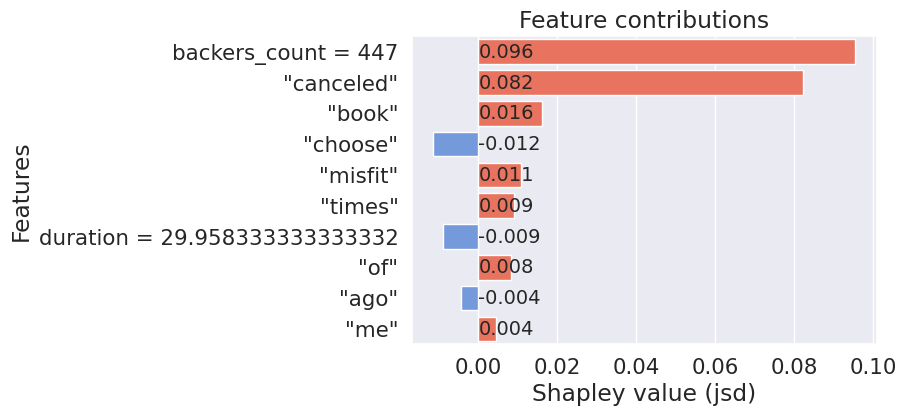

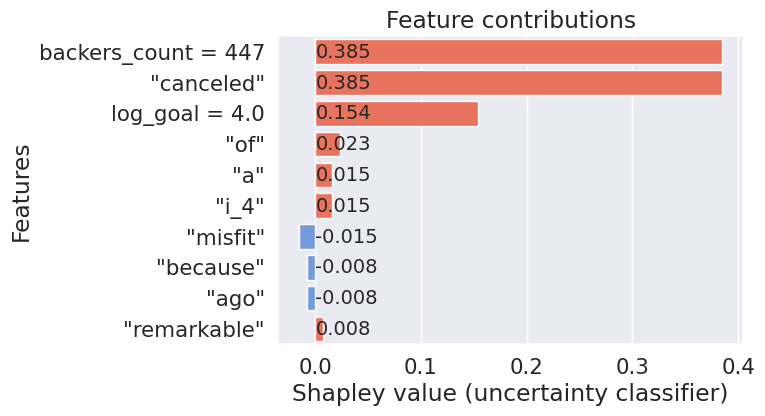

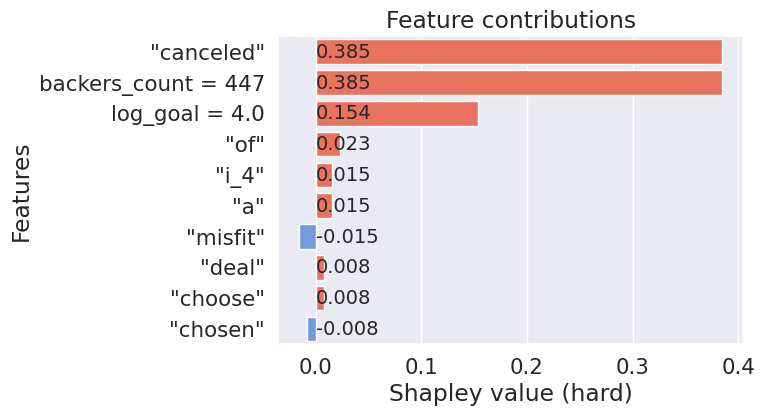

In [11]:
# compute Shapley values
shapley_result, (jsd_std, uc_std, hard_std), (x_df, perturb_df), iter_conv = compute_Shapley(instance_to_explain = instance_to_explain,
                                                                                             base_dataset = Dc,
                                                                                             model = model,
                                                                                             value_function = rf_classifier,
                                                                                             cat_vars = categorical_var_oe,
                                                                                             num_vars = numerical_var_scaled,
                                                                                             token_var = "encoded_var",
                                                                                             words=words,
                                                                                             M = 50,
                                                                                             T = 10,
                                                                                             conv_eps = 0.01,
                                                                                             seed=SEED,
                                                                                             device=device,
                                                                                             display = True)

***Consistency with Kernel Shap***

In [12]:
# compute the contribution with Kernl SHAP method
shapley_result = kernel_shap_consistency(perturb_df, x_df, shapley_result, seed=SEED)

In [13]:
consistency_res_ks = pd.DataFrame()
consistency_res_ks.loc["jsd vs ks-jsd", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (jsd)"],shapley_result["Kernel Shap (jsd)"])
consistency_res_ks.loc["uncertainty classifier vs ks-uncertainty classifier", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (uncertainty classifier)"],shapley_result["Kernel Shap (uncertainty classifier)"])
consistency_res_ks.loc["hard vs ks-hard", ["pearson correlation", "pearson p-value", "top 3+ intersection"]] = shapley_correl_intersec(shapley_result["Shapley value (hard)"],shapley_result["Kernel Shap (hard)"])
consistency_res_ks

,pearson correlation,pearson p-value,top 3+ intersection
jsd vs ks-jsd,0.96,4.400767e-21,2.0
uncertainty classifier vs ks-uncertainty classifier,0.99,1.230558e-34,3.0
hard vs ks-hard,0.73,1.530063e-07,3.0
